In [27]:
from pymongo import MongoClient

# Connect to the MongoDB container
client = MongoClient('mongodb://localhost:27017')
db = client.linkedin_crawler

# Get all posts for analysis
posts = list(db.posts.find())

In [28]:
posts

[{'_id': ObjectId('671b4e5d18abfbdc5763c8c7'),
  'content': "NetworkX andNVIDIAco-developed a GPU-accelerated backend powered by NVIDIA cuGraph, to accelerate  popular graph algorithms like betweenness centrality, Louvain, and PageRank. Depending on the algorithm and graph size, users can expect to see significant performance gains on NetworkX workflows - up to 50x, even 500x over NetworkX on CPU.With zero code changes developers can run NetworkX powered by cuGraph on NVIDIA GPUs for larger graphs and faster performance.Check it outhttps://lnkd.in/ggxAjJPJOverview: NetworkX accelerated by cuGraph1. NetworkX is an open source high performance graph analytics library that is now GPU-accelerated with NVIDIA's cuGraph library.2. The NetworkX GPU engine powered by NVIDIA nx-cuGraph is now available for general access.3. With zero code changes developers can run NetworkX accelerated by cuGraph for NVIDIA GPUs.4. NetworkX powered by cuGraph can achieve a range of speed ups from 63x up to 487x

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re

def convert_timestamp_to_datetime(timestamp_str, crawled_at):
    """Convert relative timestamp to actual datetime"""
    crawled_at = pd.to_datetime(crawled_at)
    
    # Extract number and unit from timestamp
    pattern = r'(\d+)?\s*(\w+)\s+ago'
    match = re.match(pattern, timestamp_str)
    
    if not match:
        return None
        
    number = int(match.group(1)) if match.group(1) else 1
    unit = match.group(2).lower()
    
    # Convert unit to timedelta
    if 'minute' in unit:
        delta = timedelta(minutes=number)
    elif 'hour' in unit:
        delta = timedelta(hours=number)
    elif 'day' in unit:
        delta = timedelta(days=number)
    elif 'week' in unit:
        delta = timedelta(weeks=number)
    elif 'month' in unit:
        delta = timedelta(days=number*30)  # Approximate
    else:
        return None
        
    return crawled_at - delta

In [31]:
df=pd.DataFrame(posts)

In [32]:
df['media_type'].value_counts()

media_type
video    551
image    536
Name: count, dtype: int64

In [33]:
# Create posting_time column
df['posting_time'] = df.apply(lambda x: convert_timestamp_to_datetime(x['timestamp'], x['crawled_at']), axis=1)
# Add month-year column for frequency analysis
df['month_year'] = df['posting_time'].dt.to_period('M')

In [34]:
def analyze_linkedin_posts(df):
    # 1. Calculate Average Monthly Posting Frequency
    monthly_frequency = df.groupby('month_year').size().mean()
    
    # 2. Calculate Average Post Length
    avg_post_length = df['content'].str.len().mean()
    
    # 3 & 4. Media Analysis
    media_metrics = df.groupby('media_type').agg({
        'likes_count': 'mean',
        'comments_count': 'mean'
    }).round(2)
    
    # 5. Additional Metrics
    df['engagement_ratio'] = np.where(
    df['likes_count'] > 0,
    df['comments_count'] / df['likes_count'],
    0  # Set to 0 when likes_count is 0
    )
    
    # Cap engagement ratio at 95th percentile to handle outliers
    engagement_cap = df['engagement_ratio'].quantile(0.95)
    df['engagement_ratio'] = df['engagement_ratio'].clip(upper=engagement_cap)
    
    avg_engagement_ratio = df['engagement_ratio'].mean()
    
    # Time of Day Analysis
    df['hour_of_day'] = df['posting_time'].dt.hour
    posting_hour_dist = df.groupby('hour_of_day').size()
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Average Likes by Media Type
    plt.subplot(2, 2, 1)
    media_metrics['likes_count'].plot(kind='bar')
    plt.title('Average Likes by Media Type')
    plt.xlabel('Media Type')
    plt.ylabel('Average Likes')
    plt.xticks(rotation=45)
    
    # Plot 2: Average Comments by Media Type
    plt.subplot(2, 2, 2)
    media_metrics['comments_count'].plot(kind='bar')
    plt.title('Average Comments by Media Type')
    plt.xlabel('Media Type')
    plt.ylabel('Average Comments')
    plt.xticks(rotation=45)
    
    # Plot 3: Posting Time Distribution
    plt.subplot(2, 2, 3)
    posting_hour_dist.plot(kind='bar')
    plt.title('Posts Distribution by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    
    # Plot 4: Engagement Ratio Distribution
    plt.subplot(2, 2, 4)
    plt.hist(df['engagement_ratio'].dropna(), bins=20)
    plt.title('Distribution of Engagement Ratio')
    plt.xlabel('Engagement Ratio (Comments/Likes)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    
    # Return metrics
    metrics = {
        'avg_monthly_posting_frequency': monthly_frequency,
        'avg_post_length': avg_post_length,
        'media_metrics': media_metrics,
        'avg_engagement_ratio': avg_engagement_ratio,
        'best_posting_hour': posting_hour_dist.idxmax()
    }
    
    return metrics, plt.gcf()

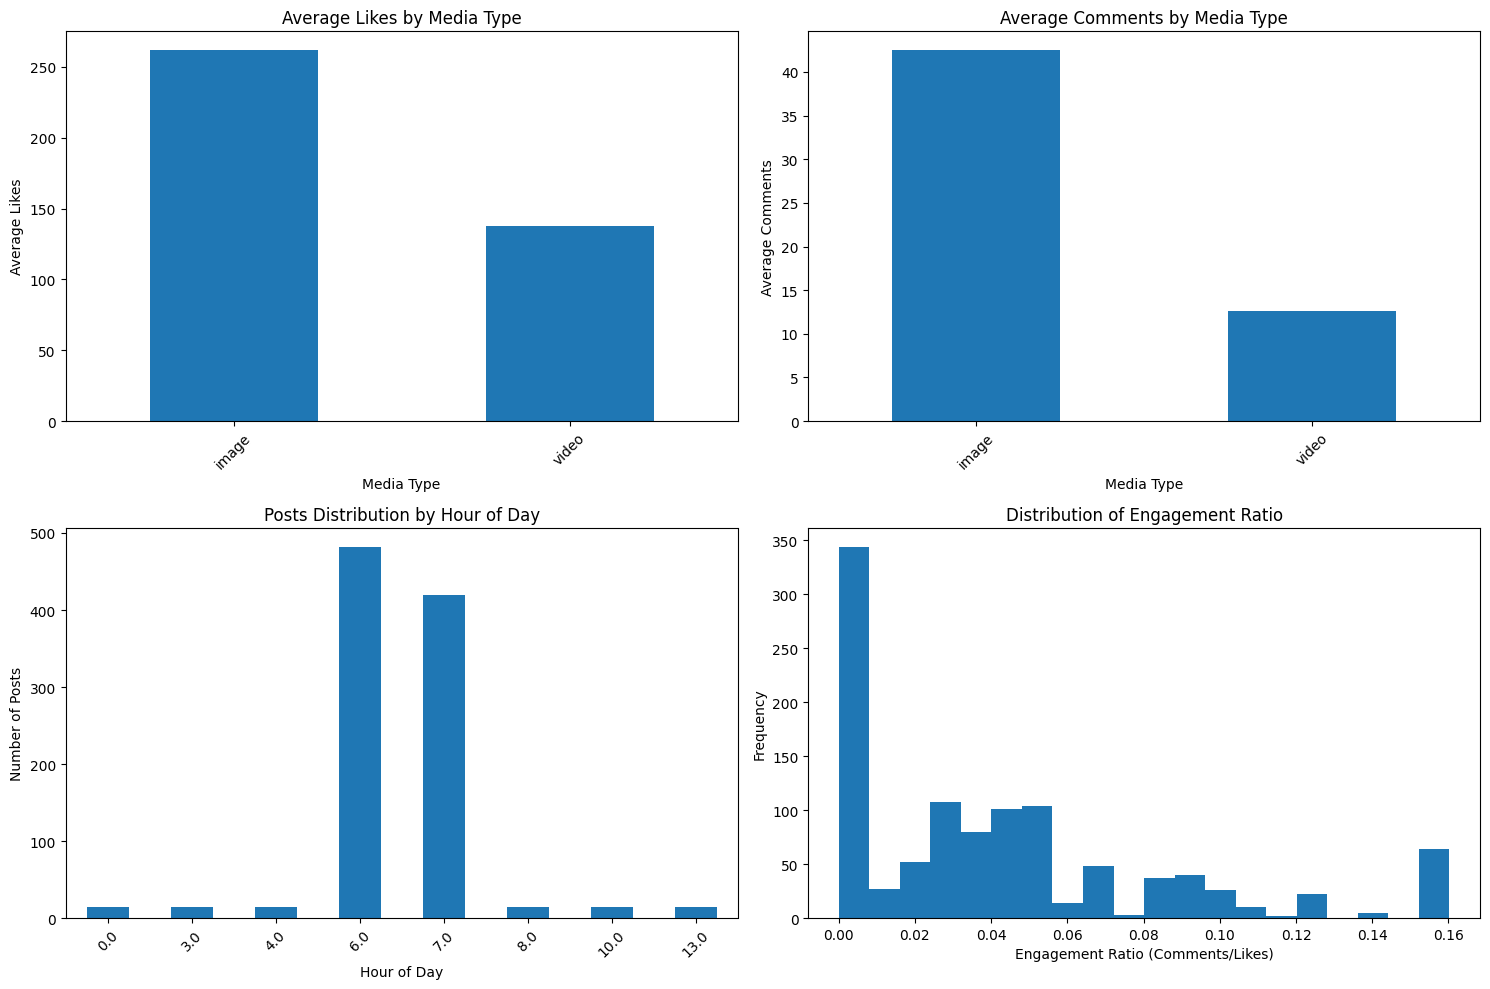

In [35]:
# Example usage:
# df = your_dataframe_here
metrics, fig = analyze_linkedin_posts(df)

In [38]:
# Print metrics
print("\nLinkedIn Posts Analysis Metrics:")
print("---------------------------------")
print(f"Average Monthly Posting Frequency: {metrics['avg_monthly_posting_frequency']:.2f} posts")
print(f"Average Post Length: {metrics['avg_post_length']:.2f} characters")
print("\nMedia Metrics:")
print(metrics['media_metrics'])
print(f"\nAverage Engagement Ratio: {metrics['avg_engagement_ratio']:.2f}")
print(f"Best Posting Hour: {metrics['best_posting_hour']}")

# Show plots
plt.show()


LinkedIn Posts Analysis Metrics:
---------------------------------
Average Monthly Posting Frequency: 109.89 posts
Average Post Length: 892.24 characters

Media Metrics:
            likes_count  comments_count
media_type                             
image            262.07           42.52
video            138.01           12.63

Average Engagement Ratio: 0.04
Best Posting Hour: 6.0
